# Carregamento dos dados de Treino e Teste

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/Geronimonetto/ChurnPrevisibility/main/data/trusted/ChurnDataset_train.parquet"

df = pd.read_parquet(url)

print("Dataset baixado e carregado com sucesso!")


Dataset baixado e carregado com sucesso!


In [38]:
df.head()

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,OverageRatio,AvgDayMinsPerCall,HighCustServCalls,NoContractRenewal,Churn
3286,106,1,1,3.54,0,220.1,105,92.4,11.11,13.1,0.118951,2.076415,0,0,0
86,94,1,0,0.00,4,157.9,105,41.0,7.75,8.0,0.184524,1.489623,1,0,1
1349,71,1,1,1.51,2,141.4,107,53.1,8.15,5.6,0.150647,1.309259,0,0,0
1649,130,1,0,0.00,0,68.4,86,29.0,9.67,10.4,0.322333,0.786207,0,0,0
3000,87,1,0,0.42,3,223.2,109,53.2,6.38,14.5,0.117712,2.029091,1,0,0


# 4. Modelagem

## Separação treino / validação

A separação estratificada garante que as proporções de cada classe sejam mantidas nos conjuntos de treino e teste, evitando desbalanceamento que poderia enviesar o modelo.

In [2]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Churn'])
y = df['Churn']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


## Regressão Logística        

Modelo baseline simples para comparação. Fornece probabilidades calibradas através da função logística.

In [3]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)


c:\Users\GERONIMO\Documents\ProjectDataScientist\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [4]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_lr = model_lr.predict(X_val)
y_proba_lr = model_lr.predict_proba(X_val)[:,1]

print(classification_report(y_val, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_val, y_proba_lr))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       457
           1       0.57      0.16      0.24        77

    accuracy                           0.86       534
   macro avg       0.72      0.57      0.58       534
weighted avg       0.83      0.86      0.83       534

ROC AUC: 0.8215919747648412



## Random Forest

Modelo ensemble baseado em árvores que captura relações não-lineares e interações entre variáveis, geralmente com melhor desempenho em dados complexos.

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    class_weight='balanced',
    random_state=42
)

rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",12
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [6]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = rf.predict(X_val)
y_proba = rf.predict_proba(X_val)[:,1]

print(classification_report(y_val, y_pred))
print("ROC AUC:", roc_auc_score(y_val, y_proba))


              precision    recall  f1-score   support

           0       0.94      0.97      0.96       457
           1       0.81      0.65      0.72        77

    accuracy                           0.93       534
   macro avg       0.87      0.81      0.84       534
weighted avg       0.92      0.93      0.92       534

ROC AUC: 0.9266247975219529


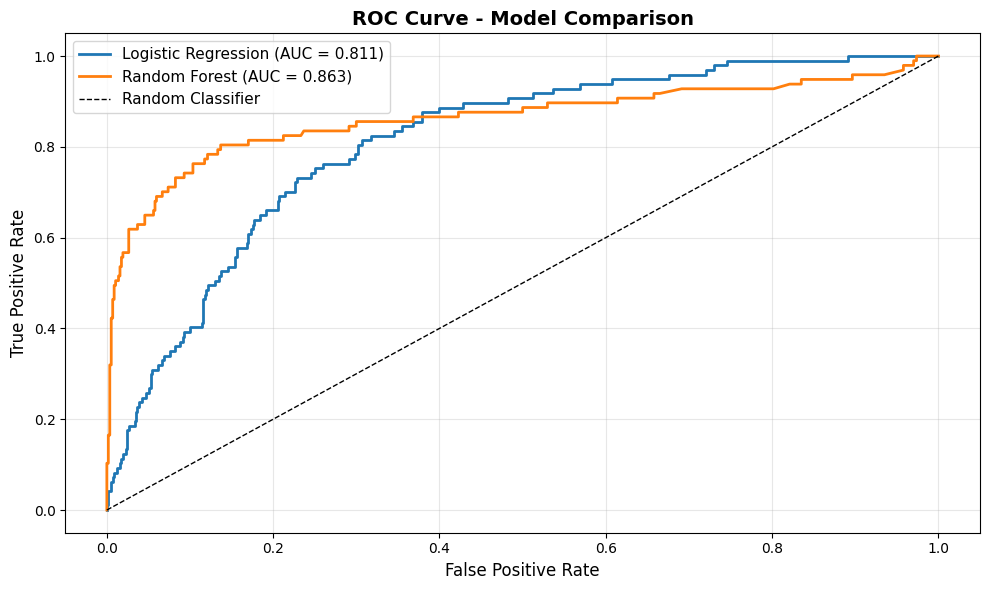

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular curva ROC para ambos os modelos
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_proba)

auc_lr = auc(fpr_lr, tpr_lr)
auc_rf = auc(fpr_rf, tpr_rf)

# Plotar
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
import pandas as pd

imp = pd.Series(rf.feature_importances_, index=X.columns)
imp.sort_values(ascending=False).head(10)


DayMins              0.161919
MonthlyCharge        0.133267
CustServCalls        0.132612
AvgDayMinsPerCall    0.073560
OverageFee           0.066184
OverageRatio         0.062889
NoContractRenewal    0.054872
DataUsage            0.053022
RoamMins             0.052444
AccountWeeks         0.048833
dtype: float64

# 5. Avaliação

Nesta seção avaliamos os modelos treinados utilizando um dataset de teste completamente separado. O objetivo é validar a generalização e o desempenho real dos modelos em dados não vistos durante o treinamento, detectando possíveis problemas de overfitting.

In [7]:
import pandas as pd

url = "https://raw.githubusercontent.com/Geronimonetto/ChurnPrevisibility/main/data/trusted/ChurnDataset_test.parquet"

df_test = pd.read_parquet(url)

print("Dataset baixado e carregado com sucesso!")


Dataset baixado e carregado com sucesso!


In [8]:
# Preparar X_test e y_test a partir do dataset de teste
X_test = df_test.drop(columns=['Churn'])
y_test = df_test['Churn']

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (667, 14)
y_test shape: (667,)


In [9]:
# Avaliar Logistic Regression no dataset de teste
y_pred_lr_test = model_lr.predict(X_test)
y_proba_lr_test = model_lr.predict_proba(X_test)[:,1]

print("=" * 60)
print("LOGISTIC REGRESSION - DATASET DE TESTE")
print("=" * 60)
print(classification_report(y_test, y_pred_lr_test))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr_test))

# Avaliar Random Forest no dataset de teste
y_pred_rf_test = rf.predict(X_test)
y_proba_rf_test = rf.predict_proba(X_test)[:,1]

print("\n" + "=" * 60)
print("RANDOM FOREST - DATASET DE TESTE")
print("=" * 60)
print(classification_report(y_test, y_pred_rf_test))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf_test))

LOGISTIC REGRESSION - DATASET DE TESTE
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       570
           1       0.53      0.20      0.29        97

    accuracy                           0.86       667
   macro avg       0.70      0.58      0.60       667
weighted avg       0.83      0.86      0.83       667

ROC AUC: 0.8130765056972327

RANDOM FOREST - DATASET DE TESTE
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       570
           1       0.82      0.60      0.69        97

    accuracy                           0.92       667
   macro avg       0.88      0.79      0.82       667
weighted avg       0.92      0.92      0.92       667

ROC AUC: 0.8729064930367156


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Calcular métricas no dataset de treino (validação)
metrics_train = {
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_val, y_pred_lr),
        'Precision': precision_score(y_val, y_pred_lr),
        'Recall': recall_score(y_val, y_pred_lr),
        'F1-Score': f1_score(y_val, y_pred_lr),
        'ROC AUC': roc_auc_score(y_val, y_proba_lr)
    },
    'Random Forest': {
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1-Score': f1_score(y_val, y_pred),
        'ROC AUC': roc_auc_score(y_val, y_proba)
    }
}

# Calcular métricas no dataset de teste
metrics_test = {
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, y_pred_lr_test),
        'Precision': precision_score(y_test, y_pred_lr_test),
        'Recall': recall_score(y_test, y_pred_lr_test),
        'F1-Score': f1_score(y_test, y_pred_lr_test),
        'ROC AUC': roc_auc_score(y_test, y_proba_lr_test)
    },
    'Random Forest': {
        'Accuracy': accuracy_score(y_test, y_pred_rf_test),
        'Precision': precision_score(y_test, y_pred_rf_test),
        'Recall': recall_score(y_test, y_pred_rf_test),
        'F1-Score': f1_score(y_test, y_pred_rf_test),
        'ROC AUC': roc_auc_score(y_test, y_proba_rf_test)
    }
}

# Criar DataFrames para comparação
df_train_metrics = pd.DataFrame(metrics_train).T
df_test_metrics = pd.DataFrame(metrics_test).T

print("📊 MÉTRICAS - DATASET DE TREINO (VALIDAÇÃO)")
print("=" * 80)
print(df_train_metrics.round(4))

print("\n📊 MÉTRICAS - DATASET DE TESTE")
print("=" * 80)
print(df_test_metrics.round(4))

print("\n📈 DIFERENÇA (Teste - Treino)")
print("=" * 80)
print((df_test_metrics - df_train_metrics).round(4))

📊 MÉTRICAS - DATASET DE TREINO (VALIDAÇÃO)
                     Accuracy  Precision  Recall  F1-Score  ROC AUC
Logistic Regression    0.8614     0.5714  0.1558    0.2449   0.8216
Random Forest          0.9270     0.8065  0.6494    0.7194   0.9266

📊 MÉTRICAS - DATASET DE TESTE
                     Accuracy  Precision  Recall  F1-Score  ROC AUC
Logistic Regression    0.8576     0.5278  0.1959    0.2857   0.8131
Random Forest          0.9220     0.8169  0.5979    0.6905   0.8729

📈 DIFERENÇA (Teste - Treino)
                     Accuracy  Precision  Recall  F1-Score  ROC AUC
Logistic Regression   -0.0039    -0.0437  0.0400    0.0408  -0.0085
Random Forest         -0.0049     0.0104 -0.0514   -0.0289  -0.0537


# 6. Implantação

Nesta seção demonstramos como o modelo pode ser utilizado em produção. Calculamos as probabilidades de churn para cada cliente e criamos regras de negócio para classificá-los em níveis de risco, permitindo ações segmentadas de retenção.

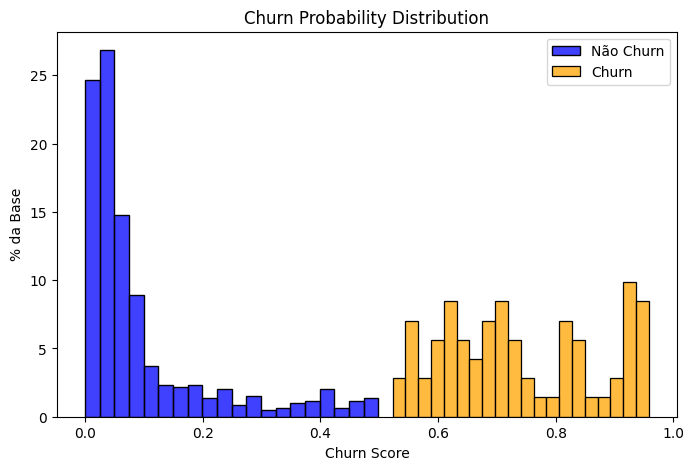

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Preparar dados tratados para predição
df_teste_treated = X_test.copy()

# Fazer predições com o melhor modelo (Random Forest)
prob_churn = rf.predict_proba(df_teste_treated)[:,1]

# Separar probabilidades por classe
prob_churn_Non_Churn = rf.predict_proba(df_teste_treated[rf.predict(df_teste_treated)==0])[:,1]
prob_churn_Positive_Churn = rf.predict_proba(df_teste_treated[rf.predict(df_teste_treated)==1])[:,1]

# Plotar distribuição de probabilidade
plt.figure(figsize=(8, 5))
sns.histplot(prob_churn_Non_Churn[:,], bins=20, stat='percent', color='blue', label='Não Churn')
sns.histplot(prob_churn_Positive_Churn[:,], bins=20, stat='percent', color='orange', label='Churn')
plt.title('Churn Probability Distribution')
plt.xlabel('Churn Score')
plt.ylabel('% da Base')
plt.legend(['Não Churn', 'Churn'])
plt.show()

In [53]:
# Regra de uso do Score
probs = rf.predict_proba(df_teste_treated)

# Classificar cada cliente
risk_classification = []

for user_churn_prob in probs[:, 1]:
    if user_churn_prob >= 0.9:
        risk_classification.append('Alto risco de churn')
    elif user_churn_prob > 0.75:
        risk_classification.append('Médio risco de churn')
    else:
        risk_classification.append('Baixo risco de churn')

# Criar DataFrame com resultados
df_result = pd.DataFrame({
    'Churn_Probability': probs[:, 1],
    'Risk_Classification': risk_classification
})

# Exibir distribuição de riscos
print("=" * 60)
print("DISTRIBUIÇÃO DE RISCO DE CHURN")
print("=" * 60)
print(df_result['Risk_Classification'].value_counts())
print("\n" + "=" * 60)
print("ESTATÍSTICAS DE PROBABILIDADE POR RISCO")
print("=" * 60)
print(df_result.groupby('Risk_Classification')['Churn_Probability'].describe())

DISTRIBUIÇÃO DE RISCO DE CHURN
Risk_Classification
Baixo risco de churn    638
Alto risco de churn      15
Médio risco de churn     14
Name: count, dtype: int64

ESTATÍSTICAS DE PROBABILIDADE POR RISCO
                      count      mean       std       min       25%       50%  \
Risk_Classification                                                             
Alto risco de churn    15.0  0.934095  0.018685  0.901965  0.921554  0.932909   
Baixo risco de churn  638.0  0.131266  0.176587  0.000342  0.027272  0.053731   
Médio risco de churn   14.0  0.822379  0.032427  0.750876  0.811772  0.824075   

                           75%       max  
Risk_Classification                       
Alto risco de churn   0.953853  0.958207  
Baixo risco de churn  0.141575  0.746632  
Médio risco de churn  0.842824  0.878732  


In [73]:
import os
import pickle

# Criar pasta 'models' se não existir
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Salvar modelo Logistic Regression
with open(os.path.join(models_dir, 'logistic_regression_model.pkl'), 'wb') as f:
    pickle.dump(model_lr, f)
print("✅ Logistic Regression salvo em: ../models/logistic_regression_model.pkl")

# Salvar modelo Random Forest
with open(os.path.join(models_dir, 'random_forest_model.pkl'), 'wb') as f:
    pickle.dump(rf, f)
print("✅ Random Forest salvo em: ../models/random_forest_model.pkl")

print("\n📦 Modelos salvos com sucesso!")
print(f"📁 Localização: {os.path.abspath(models_dir)}")

✅ Logistic Regression salvo em: ../models/logistic_regression_model.pkl
✅ Random Forest salvo em: ../models/random_forest_model.pkl

📦 Modelos salvos com sucesso!
📁 Localização: c:\Users\GERONIMO\Documents\ProjectDataScientist\models


# Explicabilidade do Modelo

shap_values_rf shape: (534, 14, 2)


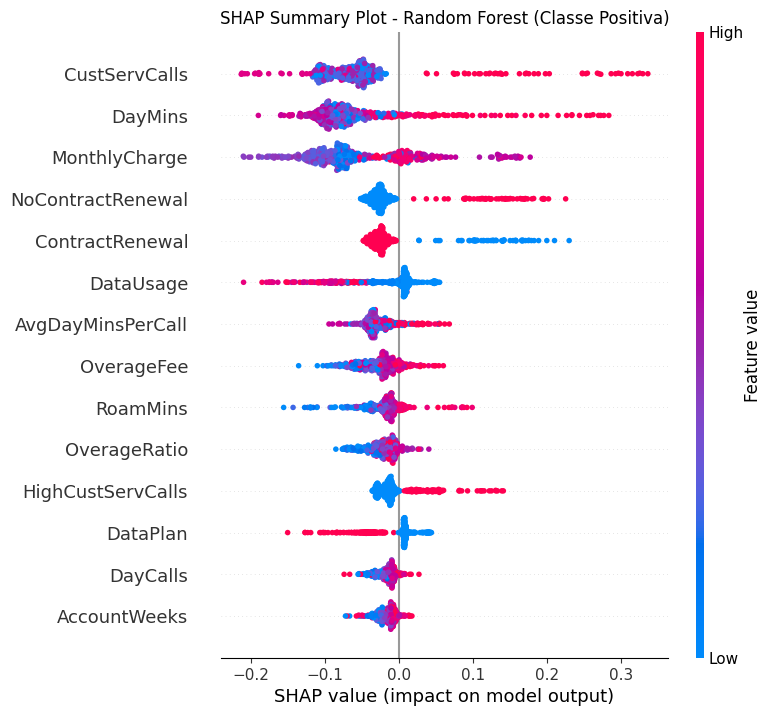

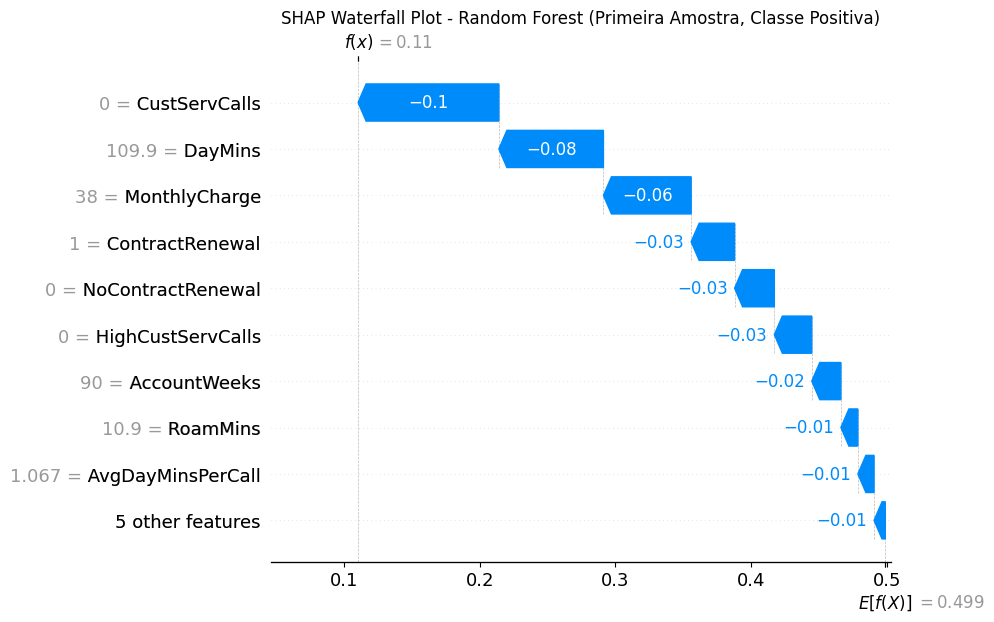

shap_values_lr shape: (534, 14)


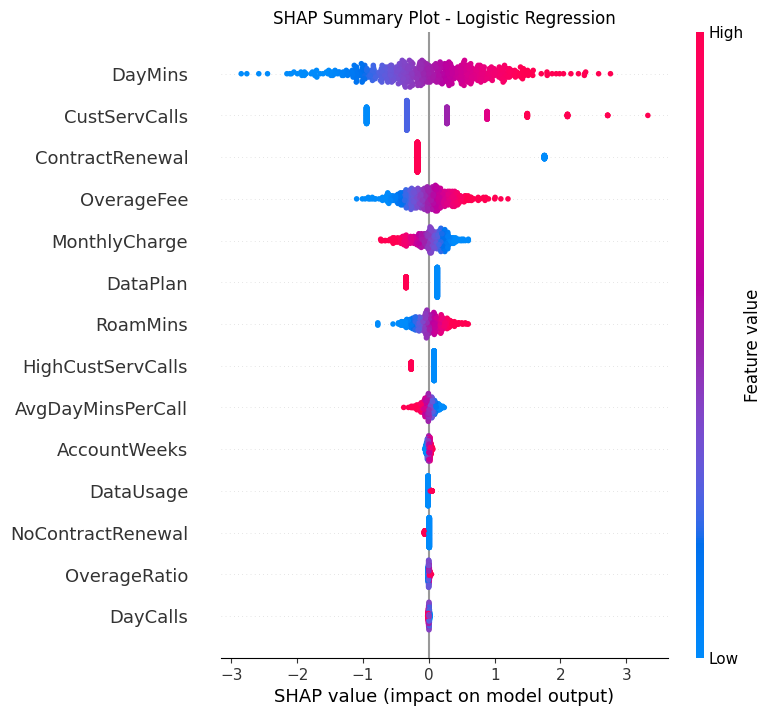

In [14]:
import shap
import matplotlib.pyplot as plt

# Explicação do modelo Random Forest usando SHAP
explainer_rf = shap.Explainer(rf)
shap_values_rf = explainer_rf(X_val)

print("shap_values_rf shape:", shap_values_rf.shape)

# Para classe positiva (Churn=1), usar [:, :, 1]
shap_values_rf_pos = shap_values_rf[:, :, 1]

# Summary plot para visualizar a importância das features
shap.summary_plot(shap_values_rf_pos, show=False)
plt.title('SHAP Summary Plot - Random Forest (Classe Positiva)')
plt.show()

# Waterfall plot para uma amostra específica (primeira do conjunto de validação)
shap.plots.waterfall(shap_values_rf[0, :, 1], show=False)
plt.title('SHAP Waterfall Plot - Random Forest (Primeira Amostra, Classe Positiva)')
plt.show()

# Explicação da Regressão Logística
explainer_lr = shap.LinearExplainer(model_lr, X_train)
shap_values_lr = explainer_lr(X_val)

print("shap_values_lr shape:", shap_values_lr.shape)

shap.summary_plot(shap_values_lr, show=False)
plt.title('SHAP Summary Plot - Logistic Regression')
plt.show()